# CS 152 Assignment 1

## Ewan Dlmss and Monica Yao

For this assignment, we referred to the cs152 notebooks from lessons 1 and 2, and the fastai "documentations" on GitHub. We looked through the [dataset file](https://github.com/fastai/fastai/blob/master/fastai/dataset.py) and the [models file](https://github.com/fastai/fastai/tree/master/fastai/models) to learn how to import data from CSV, and to find a different resnet model.

## Classifying Dogs by their Breeds

Here, we include these lines to get automatic reloading and inline plotting for our notebook. We also import the libraries that we will need from fastai, which is what we use to train our model for dog breed identification. 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/edelamusse/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The model used for this assignment will be a pre-trained model. The model is the resenet34 from fastai.
We set the ``PATH`` to the path that we have designated for our data. Sz is the size of our image.

In [4]:
arch=resnet34
PATH = "/home/edelamusse/data/competitions/dog-breed-identification/"
sz=224

We check if the frame work for NVidia GPU is avaliable, and if CuDNN is avaliable, which will improve our performance and is specifically meant for deep learning.

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

## Looking at the data

We make sure that we change into the correct directory where all of our work will be done for dog breed identification.

In [7]:
cd {PATH}

/home/edelamusse/data/competitions/dog-breed-identification


We download the dataset from Kaggle, and unzip all of the files. (Commented out because this is only done once intially)

In [8]:
#!kaggle competitions download -c dog-breed-identification
os.listdir(PATH)
#!unzip '*.zip'
#!rm *.zip

['train', 'sample_submission.csv', 'labels.csv', 'tmp', 'models', 'test']

We read the first 5 pictures of the train dataset and show them. We see that the training data are all jpg pictures.

In [9]:
files = os.listdir(f'{PATH}train')[:5]
files

['ec1654e55864cef34ec43800744f8ac2.jpg',
 'f52a0aaff41a517be216bf41c967a751.jpg',
 '6b8ac349a4550590b06c83996ed714e8.jpg',
 '96a7a15ba427e697067d62c8cef5a23a.jpg',
 '593d494b3c91921a8c6db19d00b8b4f1.jpg']

We look at the data in its picture form, as well as its raw form in matrix structure.

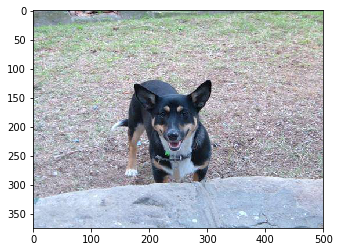

In [10]:
img = plt.imread(f'{PATH}train/{files[0]}')
plt.imshow(img);

In [11]:
img.shape

(375, 500, 3)

In [12]:
img[:4,:4]

array([[[181, 173, 186],
        [187, 179, 192],
        [188, 182, 194],
        [184, 181, 192]],

       [[167, 161, 171],
        [173, 167, 179],
        [176, 170, 182],
        [172, 169, 180]],

       [[151, 148, 157],
        [155, 152, 161],
        [154, 153, 161],
        [148, 147, 155]],

       [[146, 147, 152],
        [150, 151, 156],
        [149, 150, 155],
        [142, 143, 148]]], dtype=uint8)

## Using fastai to obtain a model

First, we decided that we will only take 10% of the training dataset for validation.

In [13]:
print(len(list(open(f'{PATH}labels.csv')))*0.1)

1022.3000000000001


In [14]:
labels_file = f'{PATH}labels.csv'
val_size = int(len(list(open(labels_file)))*0.1)
val_idxs = get_cv_idxs(val_size)

Then, we imported our data from the csv file that was provided. We referred to the fastai code to set our parameters. We also started with augmentations initially because it was a change that would decrease our validation loss, since we will not be overfitting.

We also decided to use an initial learning rate of 0.01, with 18 epochs so we can see how well our model is doing. If it is overfitting, we will decrease the number of epochs.

In [15]:
data = ImageClassifierData.from_csv(PATH, 'train', labels_file, val_idxs=val_idxs, test_name = 'test', suffix='.jpg', tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1))

In [16]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [17]:
learn.fit(0.01, 18)

epoch      trn_loss   val_loss   accuracy   
    0      1.781411   0.938068   0.784314  
    1      0.93736    0.651271   0.784314  
    2      0.719485   0.553659   0.818627  
    3      0.618003   0.519823   0.843137  
    4      0.554369   0.486344   0.818627  
    5      0.484494   0.468411   0.852941  
    6      0.452374   0.47299    0.857843  
    7      0.418774   0.440572   0.852941  
    8      0.386438   0.454242   0.852941  
    9      0.372558   0.430743   0.867647  
    10     0.352362   0.454025   0.857843  
    11     0.333178   0.445259   0.852941  
    12     0.314177   0.43221    0.882353  
    13     0.287797   0.468984   0.848039  
    14     0.273629   0.454425   0.862745  
    15     0.250705   0.479784   0.852941  
    16     0.248991   0.451843   0.852941  
    17     0.241293   0.461708   0.852941  



[array([0.46171]), 0.8529411776393068]

We see that our accuracy is not very high, and our validation loss is not very low. So from here, we will change the learning rate to see if we can make our model better.

### Changing the learning rate

We want to find a more optimal learning rate for our model. We use `` learn.lr_find`` to find a learning rate that will decrease our validation loss.

In [43]:
lrf = learn.lr_find()

 80%|███████▉  | 125/157 [00:02<00:00, 50.44it/s, loss=0.433]


# SHOULD WE DELETE?
We plot the learning rate scheduler to see ...? I don't think we actually need this

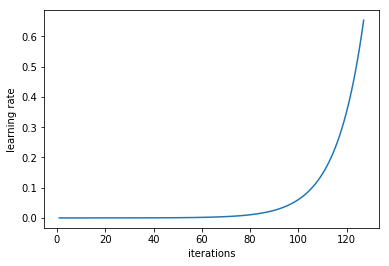

In [44]:
learn.sched.plot_lr()

We graph the validation loss along with our learning rate.

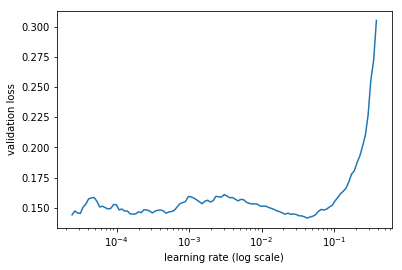

In [45]:
learn.sched.plot()

We see that at lr=0.01, our validation loss was actually going up. So, we decided to change our learning rate to lr=0.001, because that is where our validation loss was still decreasing.

## Updating our model using our new learning rate

We decided to update our learning rate, but because our learning rate was lower and we are updating the weights less frequently, we must increase the number of epochs. Again, if we see that our model begins to overfit, we will decrease the number of epochs.

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.001, 100)

epoch      trn_loss   val_loss   accuracy   
    0      4.444291   3.683168   0.294118  
    1      3.366725   2.696989   0.52451   
    2      2.638104   2.064669   0.637255  
    3      2.137732   1.647181   0.681373  
    4      1.829285   1.366815   0.745098  
    5      1.572786   1.189772   0.769608  
    6      1.403431   1.049106   0.779412  
    7      1.252565   0.950301   0.789216  
    8      1.165022   0.884364   0.779412  
    9      1.078049   0.818026   0.803922  
    10     1.040809   0.754485   0.803922  
    11     0.96147    0.732144   0.818627  
    12     0.923224   0.687887   0.828431  
    13     0.884866   0.678349   0.818627  
    14     0.823793   0.646139   0.823529  
    15     0.825849   0.626591   0.808824  
    16     0.777828   0.603232   0.838235  
    17     0.765545   0.585828   0.823529  
    18     0.742638   0.578153   0.828431  
    19     0.727286   0.555381   0.833333  
    20     0.70926    0.547766   0.818627  
    21     0.685163   0.537232 

[array([0.40149]), 0.8676470599922479]

Interestingly enough, our validation loss did not increase after a while, but stabilized at around 85 epochs. We will stay with lr=0.001 and epoch=100 for our model, since we are seeing there was nothing wrong with 100 epochs, though there might be a more optimal epoch that we don't see.

## Writing predictions of test data to output CSV

We look at the different classes that we have extracted from the CSV file (but only the first ten since there are many dog breeds).

In [29]:
data.classes[:10]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

We also look at the different test data that we were given. Then we made predictions for the test data using our model. 

In [30]:
data.test_ds.fnames[:10]

['test/f1705303b30da3a48db2a5f34376b947.jpg',
 'test/a9b79809bc1301f8d148e15bfecf6485.jpg',
 'test/cc94a3bb7191a247f59e1540d8430c93.jpg',
 'test/f7b489a38302afc010d8a386a1b7d085.jpg',
 'test/6e21c96226078576342ca66e25eb1aa9.jpg',
 'test/f16eed64196d24c423f0a68d7ebf287d.jpg',
 'test/635f438cd68b65dd6b4e100b338015fd.jpg',
 'test/b827855f566b9569fd668d990854ad0b.jpg',
 'test/5d1e83adfaac47f754f16021615fc8bf.jpg',
 'test/8a08c0b0d4554a270f66f2f16278ee70.jpg']

In [31]:
log_preds, y = learn.predict_with_targs(is_test=True)
probs = np.exp(log_preds)

We see that there are 10357 pictures in test data, and 120 classes of dog breeds that we sorted them into.

In [32]:
probs.shape

(10357, 120)

We look at the probabilities for all of the dogs to be the dog of the first class, in other words, the probability of all the dogs to be an affenpinscher. Each vector in the probability matrix corresponds to a specific class of dogs. The same index in all the vectors refers to one test image.

In [33]:
# All the probabilities for the first class
probs[:,0] 

array([0.     , 0.00004, 0.     , ..., 0.00001, 0.00002, 0.     ], dtype=float32)

In [34]:
# All the probabilities for all the classes
probs[:,:] 

array([[0.     , 0.     , 0.00001, ..., 0.0003 , 0.     , 0.     ],
       [0.00004, 0.     , 0.00003, ..., 0.00001, 0.00008, 0.00002],
       [0.     , 0.00001, 0.     , ..., 0.     , 0.00001, 0.     ],
       ...,
       [0.00001, 0.     , 0.00001, ..., 0.00002, 0.54926, 0.00001],
       [0.00002, 0.     , 0.00027, ..., 0.00005, 0.00004, 0.00003],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ]], dtype=float32)

We load our probability into a Pandas DataFrame, labeling columns as the classes, and inserting an id column with the jpg name of our test images.

In [35]:
df = pd.DataFrame(probs)

In [36]:
df.columns = [c for c in data.classes]

In [37]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

We look at both the top and bottom of our dataframe to make sure that there are 120 columns and 10357 rows.

In [38]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,f1705303b30da3a48db2a5f34376b947,3.323970e-07,0.000003,1.279338e-05,0.000229,4.637307e-04,2.730067e-07,4.482802e-07,2.083418e-07,2.019395e-07,...,1.434422e-07,5.096578e-06,8.209290e-02,1.263891e-05,7.807864e-01,4.253746e-07,2.775381e-08,2.980439e-04,5.380742e-07,2.710731e-07
1,a9b79809bc1301f8d148e15bfecf6485,4.414658e-05,0.000004,3.424033e-05,0.000005,8.181758e-05,1.566147e-03,5.454183e-05,2.991332e-05,2.592129e-05,...,1.263912e-05,2.216387e-04,8.030164e-06,1.536159e-04,3.248416e-05,6.743796e-05,4.516921e-02,1.444488e-05,8.071268e-05,2.451507e-05
2,cc94a3bb7191a247f59e1540d8430c93,3.109937e-06,0.000010,7.349575e-07,0.000001,1.096517e-07,1.292167e-02,1.430994e-06,1.187012e-06,1.203433e-05,...,2.281445e-06,2.895032e-07,4.079054e-07,9.252161e-06,2.778505e-07,1.219652e-05,1.495375e-06,2.073713e-07,5.478468e-06,1.946279e-06
3,f7b489a38302afc010d8a386a1b7d085,8.595425e-07,0.000002,5.618533e-07,0.000007,1.687983e-06,2.900420e-02,6.496984e-07,4.684985e-06,9.215123e-06,...,3.868342e-06,4.111703e-08,2.046050e-07,1.737245e-05,2.900869e-07,3.224516e-06,2.544896e-07,3.699968e-07,9.197910e-07,7.871194e-07
4,6e21c96226078576342ca66e25eb1aa9,7.172510e-04,0.000009,1.585225e-06,0.000033,3.102562e-07,4.026449e-06,3.927714e-07,5.696692e-07,2.166853e-07,...,1.373650e-07,6.076972e-07,3.003425e-06,8.270287e-07,5.292194e-06,4.132327e-07,8.127359e-07,2.288470e-06,6.932675e-06,6.972258e-06


In [39]:
df.tail()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
10352,41e2f002c3bae9485ea22aa1919e2492,1.040844e-06,4.178381e-08,2.526096e-09,1.772354e-07,6.313988e-08,6.374466e-08,4.472426e-03,1.997865e-08,3.689177e-10,...,2.363052e-07,1.023074e-06,1.775918e-08,9.205474e-09,4.314587e-08,1.008514e-08,7.588555e-07,1.632298e-10,4.206285e-07,0.003239
10353,97e2e37ee031e716ba2d56da4d7c84f2,8.690321e-05,3.409308e-03,5.236570e-04,4.845149e-04,1.688276e-05,3.480192e-04,2.863857e-05,7.809702e-05,8.132256e-04,...,2.060968e-04,2.858327e-04,6.024542e-05,4.912406e-04,1.004189e-04,4.959500e-04,8.532791e-04,2.491844e-02,2.256952e-03,0.000091
10354,58f4e60b2dd5c940a5db978de6b715df,8.840580e-06,1.673353e-06,9.850132e-06,4.951142e-05,3.254795e-05,2.482420e-06,1.071202e-05,8.120557e-05,8.909048e-05,...,4.506379e-04,2.243703e-03,1.556892e-06,2.323675e-04,5.481415e-06,7.542541e-06,3.153048e-02,1.789887e-05,5.492560e-01,0.000009
10355,3e764ad13028326c980cdb1263e70ef0,1.976164e-05,1.650082e-06,2.747244e-04,4.749845e-06,3.140016e-04,9.355837e-05,1.689526e-05,3.022929e-03,3.925299e-05,...,1.631777e-04,6.074018e-02,4.394185e-07,8.576147e-06,8.912153e-06,8.066151e-05,7.882997e-05,4.963974e-05,3.500618e-05,0.000027
10356,f4eb5c8121abd476cfc36684e74e83a5,4.109745e-07,1.899368e-08,5.540226e-09,2.543186e-09,1.162156e-09,6.515841e-09,2.070793e-08,6.269759e-10,9.157175e-09,...,2.234968e-09,7.780022e-08,4.149470e-09,1.689822e-09,3.090662e-08,1.493663e-08,7.991336e-07,1.817461e-08,5.239804e-08,0.000004


We write our submission CSV file into an out directory, and we uploaded it to Kaggle, which gave us the following results.

In [40]:
SUBM = f'../../out/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}dogsbreed.gz', compression='gzip', index=False)

This is the results we obtained with data augmentations, lr = 0.001, and epoch = 100.

![Original Result](100ep.001lr.PNG "Original Result")

We got a score of around 0.47, which we think we can improve.


## Using other fastai resnets

We saw that there were different resnets with the fastai library, so we decided to test it out a little. First, we ran resnet50 first, which has more layers. We chose to test with resnet50, data augmentation, learning rate = 0.01, 10 epochs because it would be quick. We simply put everything into one cell, but it is all the same steps as before but just all in one.

In [42]:
arch=resnet50
data = ImageClassifierData.from_csv(PATH, 'train', labels_file, val_idxs=val_idxs, test_name = 'test', suffix='.jpg', tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 10)
log_preds, y = learn.predict_with_targs(is_test=True)
probs = np.exp(log_preds)
df = pd.DataFrame(probs)
df.columns = [c for c in data.classes]
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])
SUBM = f'../../out/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}dogsbreed.gz', compression='gzip', index=False)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/edelamusse/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 39903960.33it/s]


100%|██████████| 162/162 [01:34<00:00,  1.59it/s]


epoch      trn_loss   val_loss   accuracy   
    0      1.121176   0.581392   0.882353  
    1      0.615277   0.42183    0.882353  
    2      0.46205    0.372411   0.872549  
    3      0.358922   0.368396   0.892157  
    4      0.323259   0.335759   0.892157  
    5      0.288165   0.317276   0.901961  
    6      0.251959   0.319481   0.897059  
    7      0.211895   0.325542   0.892157  
    8      0.184945   0.315736   0.906863  
    9      0.171991   0.31742    0.911765  



![New Resnet Result](10ep.01lr.PNG "New Resnet Result")

We saw that our validation loss is lower than the one we had with resnet34, and our accuracy is higher already. Our kaggle score is better too! We decided to use resnet50 again, but instead with the optimal learning rate and epochs that we have found before. 

Testing with resnet50, data augmentation, learning rate = 0.001, 100 epochs.

In [46]:
arch=resnet50
data = ImageClassifierData.from_csv(PATH, 'train', labels_file, val_idxs=val_idxs, test_name = 'test', suffix='.jpg', tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.001, 100)
log_preds, y = learn.predict_with_targs(is_test=True)
probs = np.exp(log_preds)
df = pd.DataFrame(probs)
df.columns = [c for c in data.classes]
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])
SUBM = f'../../out/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}dogsbreed.gz', compression='gzip', index=False)

epoch      trn_loss   val_loss   accuracy   
    0      3.251806   2.329318   0.637255  
    1      1.972378   1.467514   0.769608  
    2      1.439963   1.100379   0.808824  
    3      1.156315   0.895944   0.862745  
    4      0.968321   0.788931   0.857843  
    5      0.881086   0.710082   0.852941  
    6      0.780538   0.646703   0.867647  
    7      0.729675   0.597566   0.862745  
    8      0.667275   0.569692   0.843137  
    9      0.616639   0.542005   0.877451  
    10     0.598669   0.518062   0.852941  
    11     0.550196   0.499618   0.882353  
    12     0.544748   0.477377   0.897059  
    13     0.510946   0.46918    0.882353  
    14     0.491681   0.460898   0.867647  
    15     0.467778   0.437356   0.887255  
    16     0.456203   0.428265   0.877451  
    17     0.429267   0.429442   0.882353  
    18     0.423487   0.424086   0.877451  
    19     0.404185   0.41075    0.877451  
    20     0.394329   0.408437   0.882353  
    21     0.380967   0.401949 

![Resnet50 Result](100ep.001lrR50.PNG "Resnet50 Result")

Our accuracy was lower than 10 epochs and validation loss slightly higher, but we wanted to see if this model still generalized better than 10 epochs. From our Kaggle score, it did perform better than 10 epochs, but we can't be sure.

To finish off, we decided to try making the model with resnet101, and using the same learning rate and number of epochs as before.

Testing with resnet101, data augmentation, learning rate = 0.001, 100 epochs.

In [15]:
arch=resnet101
data = ImageClassifierData.from_csv(PATH, 'train', labels_file, val_idxs=val_idxs, test_name = 'test', suffix='.jpg', tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.001, 100)
log_preds, y = learn.predict_with_targs(is_test=True)
probs = np.exp(log_preds)
df = pd.DataFrame(probs)
df.columns = [c for c in data.classes]
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])
SUBM = f'../../out/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}dogsbreed.gz', compression='gzip', index=False)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/edelamusse/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:08<00:00, 22204046.81it/s]


100%|██████████| 162/162 [02:22<00:00,  1.07it/s]


epoch      trn_loss   val_loss   accuracy   
    0      3.017752   1.986462   0.720588  
    1      1.764049   1.21231    0.813725  
    2      1.261466   0.903565   0.867647  
    3      0.99051    0.735635   0.882353  
    4      0.838148   0.63823    0.887255  
    5      0.746983   0.576209   0.887255  
    6      0.691439   0.519757   0.892157  
    7      0.613518   0.485701   0.882353  
    8      0.564898   0.45559    0.892157  
    9      0.549128   0.432432   0.897059  
    10     0.493877   0.409837   0.892157  
    11     0.469958   0.404828   0.906863  
    12     0.444617   0.386245   0.911765  
    13     0.437835   0.379752   0.892157  
    14     0.418786   0.373776   0.911765  
    15     0.401516   0.362313   0.906863  
    16     0.387999   0.353175   0.911765  
    17     0.36351    0.348905   0.906863  
    18     0.356015   0.345654   0.906863  
    19     0.349223   0.345168   0.911765  
    20     0.318566   0.345909   0.906863  
    21     0.313756   0.33817  

With resnet101, our accuracy went even higher, and validation loss even lower. We put this into Kaggle, and saw the best score so far. 

![Resnet101 Result](100ep.001lrR101.PNG "Resnet101 Result")


We decided to submit this! 

![Kaggle Submittal](resnet101_0.001_100.PNG "Kaggle submittal")